In [57]:
print(__doc__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import check_random_state
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression

pd.options.display.float_format = "{:.1f}".format

Automatically created module for IPython interactive environment


In [58]:
def retrieve_data_recid():
    attributes = ['MarriageStatus','age','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count', 'days_b_screening_arrest','c_days_from_compas','c_charge_degree']
    bias = 'race'
    target = 'two_year_recid'

    np.random.seed(42)

    data = pd.read_csv("https://raw.githubusercontent.com/WenxuanHuang/Active-Learning-Performance-Benchmarking/main/RecidivismData_Normalized.csv", sep=',')
    data_col = data.columns
    df = data[(data[bias]==2)|(data[bias]==3)].copy().values

    kf = KFold(n_splits=4) #differ from original method
    for train_index, test_index in kf.split(df):
        train, test = df[train_index], df[test_index]
        # print("Size of X_train_full, X_test:", train.shape, test.shape)

    df_train = pd.DataFrame(data=train, columns=data_col)
    df_test = pd.DataFrame(data=test, columns=data_col)

    labeled = df_train.groupby(target, group_keys=False).apply(lambda x: x.sample(n=5, random_state = 42)) # ten sample in total labeled initially
    df_X_labeled = labeled[attributes]
    df_y_labeled = labeled[target]
    X_labeled = df_X_labeled.values
    y_labeled = df_y_labeled.values.astype('int64')
    b_labeled = labeled[bias].values-2
    (row_size, col_size) = X_labeled.shape

    unlabeled = df_train.drop(df_X_labeled.index)
    df_X_unlabeled = unlabeled[attributes]
    df_y_unlabeled = unlabeled[target]
    X_unlabeled = df_X_unlabeled.values
    y_unlabeled = df_y_unlabeled.values.astype('int64')
    b_unlabeled = unlabeled[bias].values-2

    X_test = df_test[attributes].values
    y_test = df_test[target].values
    y_test=y_test.astype('int')
    b_test = df_test[bias].values-2

    X_fair_est = X_unlabeled
    y_fair_est = y_unlabeled
    b_fair_est = b_unlabeled
    
    return (X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est)

In [59]:
class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass

class LogModel(BaseModel):

    def fit_predict(self, X_labeled, y_labeled, X_test, y_test):
        self.classifier = LogisticRegression(
            solver='liblinear'
            )
        self.classifier.fit(X_labeled, y_labeled)
        # self.y_test_predicted = self.classifier.predict(X_test)
        # self.y_unlabeled_predicted = self.classifier.predict(X_unlabeled)
        self.y_test_score = self.classifier.score(X_test, y_test)
        return (X_labeled, X_test, self.y_test_score)

In [60]:
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    def train(self, X_labeled, y_labeled, X_test, y_test):
        (X_labeled, X_test, self.y_test_score) = \
            self.model_object.fit_predict(X_labeled, y_labeled, X_test, y_test)
        return (X_labeled, X_test)

    def get_test_accuracy(self, i):
        classif_rate = self.y_test_score * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        print("Accuracy rate is %f " % (classif_rate))

In [61]:
class QueryFunction(object):

    def __init__(self):
        pass

    def pool_select(self):
        pass


class RandomSelection(QueryFunction):

    @staticmethod
    def pool_select(probas_val, batch_size):
        random_state = check_random_state(0)
        # probas_val.shape[0] is the size of validation set
        selection = np.random.choice(probas_val.shape[0], batch_size, replace=False)
        # print('uniques chosen:',np.unique(selection).shape[0],'<= should be equal to:',batch_size)
        return selection


# class EntropySelection(QueryFunction):

#     @staticmethod
#     def pool_select(probas_val, batch_size):
#         e = (-probas_val * np.log2(probas_val)).sum(axis=1)
#         selection = (np.argsort(e)[::-1])[:batch_size]
#         return selection

# class MinStdSelection(QueryFunction):

#     # select the samples where the std is smallest. There is uncertainty regarding the relevant class
#     # and then train on these "hard" to classify samples.
#     @staticmethod
#     def pool_select(probas_val, batch_size):
#         std = np.std(probas_val * 100, axis=1) 
#         selection = std.argsort()[:batch_size]
#         selection = selection.astype('int64')
#         print('std',std.shape,std)
#         print('selection',selection, selection.shape, std[selection])
#         return selection

# class LeastConfidenceSelection(QueryFunction):

#     @staticmethod
#     def pool_select(probas_val, batch_size):
#         sort_prob = -np.sort(-probas_val, axis=1)
#         values = sort_prob[:, 0]
#         selection = np.argsort(values)[:batch_size]
#         return selection
      
      
# class MarginSelection(QueryFunction):

#     @staticmethod
#     def pool_select(probas_val, batch_size):
#         sort_prob = -np.sort(-probas_val, axis=1)
#         values = sort_prob[:, 0] - sort_prob[:, 1]
#         selection = np.argsort(values)[:batch_size]
#         return selection


In [62]:
def normalizer(e_loss, f_loss):
    e_loss = np.reshape(e_loss, (1,len(e_loss)))
    f_loss = np.reshape(f_loss, (1,len(f_loss)))
    e_scaled = preprocessing.normalize(e_loss)
    # e_scaled=((e_loss-e_loss.min())/(e_loss.max()-e_loss.min()))
    f_scaled = preprocessing.normalize(f_loss)
    # f_scaled=((f_loss-f_loss.min())/(f_loss.max()-f_loss.min()))
    return (e_scaled, f_scaled)

In [63]:
def log_loss(probas_val):
    
    eps = np.finfo(probas_val.dtype).eps
    probas_val = np.clip(probas_val, eps, 1 - eps)
    e_loss = (-probas_val * np.log2(probas_val)).sum(axis=1)

    return e_loss

In [64]:
# separation \ Equal opportunity - Hardt, Price, Srebro (2016)

def eqops(X_fair_est, y_fair_est, b_fair_est, classifier):
    
    y_fair_pred = classifier.predict(X_fair_est)

    b0y1p1=X_fair_est[(b_fair_est==0)&(y_fair_pred==1)&(y_fair_est==1)].shape[0]
    b0y1=X_fair_est[(b_fair_est==0)&(y_fair_est==1)].shape[0]
    b1y1p1=X_fair_est[(b_fair_est==1)&(y_fair_pred==1)&(y_fair_est==1)].shape[0]
    b1y1=X_fair_est[(b_fair_est==1)&(y_fair_est==1)].shape[0]

    f_loss=abs((b0y1p1/b0y1)-(b1y1p1/b1y1))
    # print("Debug fair_loss shape:", b0p1, b0, b1p1, b1)
    
    return f_loss

def eqods(X_fair_est, y_fair_est, b_fair_est, classifier):
    
    y_fair_pred = classifier.predict(X_fair_est)

    b0y0p1=X_fair_est[(b_fair_est==0)&(y_fair_est==0)&(y_fair_pred==1)].shape[0]
    b0y0=X_fair_est[(b_fair_est==0)&(y_fair_est==0)].shape[0]
    b1y0p1=X_fair_est[(b_fair_est==1)&(y_fair_est==0)&(y_fair_pred==1)].shape[0]
    b1y0=X_fair_est[(b_fair_est==1)&(y_fair_est==0)].shape[0]

    b0y1p1=X_fair_est[(b_fair_est==0)&(y_fair_est==1)&(y_fair_pred==1)].shape[0]
    b0y1=X_fair_est[(b_fair_est==0)&(y_fair_est==1)].shape[0]
    b1y1p1=X_fair_est[(b_fair_est==1)&(y_fair_est==1)&(y_fair_pred==1)].shape[0]
    b1y1=X_fair_est[(b_fair_est==1)&(y_fair_est==1)].shape[0]

    fpr_loss=(b0y0p1/b0y0)-(b1y0p1/b1y0)
    tpr_loss=(b0y1p1/b0y1)-(b1y1p1/b1y1)


    f_loss = abs((fpr_loss+tpr_loss)) # temporary solution
    
    return f_loss 

def disp_mist(X_fair_est, y_fair_est, b_fair_est, classifier):
    
    y_fair_pred = classifier.predict(X_fair_est)

    b0y0p1=X_fair_est[(b_fair_est==0)&(y_fair_est==0)&(y_fair_pred==1)].shape[0]
    b0y0=X_fair_est[(b_fair_est==0)&(y_fair_est==0)].shape[0]
    b1y0p1=X_fair_est[(b_fair_est==1)&(y_fair_est==0)&(y_fair_pred==1)].shape[0]
    b1y0=X_fair_est[(b_fair_est==1)&(y_fair_est==0)].shape[0]

    b0y1p0=X_fair_est[(b_fair_est==0)&(y_fair_est==1)&(y_fair_pred==0)].shape[0]
    b0y1=X_fair_est[(b_fair_est==0)&(y_fair_est==1)].shape[0]
    b1y1p0=X_fair_est[(b_fair_est==1)&(y_fair_est==1)&(y_fair_pred==0)].shape[0]
    b1y1=X_fair_est[(b_fair_est==1)&(y_fair_est==1)].shape[0]

    fpr_loss=(b0y0p1/b0y0)-(b1y0p1/b1y0)
    fnr_loss=(b0y1p0/b0y1)-(b1y1p0/b1y1)


    f_loss = abs((fpr_loss+fnr_loss)) # temporary solution
    
    return f_loss 
    

In [65]:
# selecting fairness criteria

def fair_measure(X_fair_est, y_fair_est, b_fair_est, classifier=None, criteria=0):

    if criteria == 'equal_opportunity':
        return eqops(X_fair_est, y_fair_est, b_fair_est, classifier)
    elif criteria == 'disparate_mistreatment':
        return disp_mist(X_fair_est, y_fair_est, b_fair_est, classifier)
    elif criteria == 'equalized_odds':
        return eqods(X_fair_est, y_fair_est, b_fair_est, classifier)

In [66]:
def error_reduction_sampling(query_size, X_unlabeled, X_labeled, y_labeled, classifier, X_fair_est, y_fair_est, b_fair_est, probas_val, step, criteria):
    # further to be defined, now assume only fairness loss
    # query size used here
    div = 0

    unlabeled_size = len(X_unlabeled)
    f_loss = np.zeros(unlabeled_size)
    for i in range(unlabeled_size):
        f_loss_temp = []
        for j in range(2):
            X_labeled_temp = np.append(X_labeled, [X_unlabeled[i]], axis = 0)
            y_labeled_temp = np.append(y_labeled, [j], axis = 0)
            classifier_temp = LogisticRegression(solver='liblinear').fit(X_labeled_temp, y_labeled_temp)
            f_loss_temp = np.append(f_loss_temp, fair_measure(X_fair_est, y_fair_est, b_fair_est, classifier=classifier_temp, criteria=criteria))
            f_loss_temp[np.isnan(f_loss_temp)] = 0
            
        proba_0 = classifier.predict_proba(X_unlabeled)[i][0]
        proba_1 = 1 - proba_0
        f_loss[i] = (f_loss_temp).dot([proba_0, proba_1])

    e_loss = log_loss(probas_val)

    e_scaled, f_scaled = normalizer(e_loss, f_loss)
    f_scaled[np.isnan(f_scaled)] = 0

    loss = div*(e_loss)+(1-div)*f_loss
    
    selection = np.argsort(loss)[::-1][:step]

    return selection

In [67]:
class active_learning(object):

    def __init__(self, step, budget, model_object, selection_function, criteria):
        self.step = step
        self.budget = budget
        self.model_object = model_object
        self.sample_selection_function = selection_function
        self.criteria = criteria
        
    def run(self, X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est, sub_option):
  
        self.clf_model = TrainModel(self.model_object)
        (X_labeled, X_test) = self.clf_model.train(X_labeled, y_labeled, X_test, y_test)
        active_iteration = 1
        self.clf_model.get_test_accuracy(active_iteration)

        self.query_size = len(X_labeled)
        fairness = []
        fairness = np.append(fairness, fair_measure(X_test, y_test, b_test, classifier=self.clf_model.model_object.classifier, criteria=self.criteria))

        while self.query_size <= self.budget-self.step:

            active_iteration += 1
            self.query_size += self.step

            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_unlabeled)

            # y_unlabeled_predicted = \
            #     self.clf_model.model_object.classifier.predict(X_unlabeled)
            
            # print("Debug predicted:", y_unlabeled_predicted.shape)
            # print("Debug probas_val:", probas_val.shape)

            if sub_option == "Pre_filter":
                candidates = self.sample_selection_function.pool_select(probas_val, self.budget)
                uncertain_samples = error_reduction_sampling(self.query_size, X_unlabeled[candidates], X_labeled, y_labeled, self.clf_model.model_object.classifier, X_fair_est[candidates], y_fair_est[candidates], b_fair_est[candidates], probas_val[candidates], self.step, self.criteria)
            elif sub_option == "No_filter": 
                uncertain_samples = error_reduction_sampling(self.query_size, X_unlabeled, X_labeled, y_labeled, self.clf_model.model_object.classifier, X_fair_est, y_fair_est, b_fair_est, probas_val, self.step, self.criteria)
            elif sub_option == "Filter_only":
                uncertain_samples = self.sample_selection_function.pool_select(probas_val, self.step)

            # print("Debug shape of X_unlabeled and loss:", selection)

            # uncertain_samples = self.sample_selection_function.pool_select(probas_val, self.step)

            X_labeled = np.concatenate((X_labeled, X_unlabeled[uncertain_samples]))
            y_labeled = np.concatenate((y_labeled, y_unlabeled[uncertain_samples]))
            X_unlabeled = np.delete(X_unlabeled, uncertain_samples, axis=0)
            y_unlabeled = np.delete(y_unlabeled, uncertain_samples, axis=0)

            (X_labeled, X_test) = self.clf_model.train(X_labeled, y_labeled, X_test, y_test)
            fairness = np.append(fairness, fair_measure(X_test, y_test, b_test, classifier=self.clf_model.model_object.classifier, criteria=self.criteria))
            self.clf_model.get_test_accuracy(active_iteration)

        return self.clf_model.accuracies, fairness

In [68]:
def non_active_learning(X_unlabeled, y_unlabeled, X_labeled,y_labeled, X_test, y_test, b_test, budget, unfairness_criteria): 

    np.random.seed(21)
    nonal_initial_query = len(X_labeled)
    nonal_index = np.random.choice(np.arange(len(X_unlabeled)), budget-nonal_initial_query)
    # print(nonal_index)

    nonal_X_train = np.append(X_labeled, X_unlabeled[nonal_index], axis=0)
    nonal_y_train = np.append(y_labeled, y_unlabeled[nonal_index], axis=0)
    nonal_X_test = X_test
    nonal_y_test = y_test
    nonal_b_test = b_test
    
    nonal_fairness = []
    nonal_accuracies=[]

    classifier_nonal = LogisticRegression(
            solver='liblinear'
            )

    classifier_nonal.fit(nonal_X_train, nonal_y_train)
    nonal_y_pred = classifier_nonal.predict(nonal_X_test)
    nonal_fairness = np.append(nonal_fairness, fair_measure(nonal_X_test, nonal_y_test, nonal_b_test, classifier=classifier_nonal, criteria=unfairness_criteria))
    nonal_accuracies.append(accuracy_score(nonal_y_test, nonal_y_pred)*100)

    return nonal_accuracies, nonal_fairness

In [69]:
def experiment(model,sampling_method,budget,step,criteria,sub_option=False):
    
    (X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est) = retrieve_data_recid()
    init_index = len(X_labeled)
        
    act_alg = active_learning(step, budget, model, sampling_method, criteria)

    accuracies, fairness = act_alg.run(X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est, sub_option)

    # print('Fairness:', fairness)

    nonal_accuracies, nonal_fairness = non_active_learning(X_unlabeled, y_unlabeled, X_labeled, y_labeled, X_test, y_test, b_test, budget, criteria)

    # print("active_accuracies",accuracies)
    # print("nonactive_accuracies",nonal_accuracies)
    
    x_axis = np.arange(init_index,budget+1,step)
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('Fairness and accuracy metrics')
    ax1.plot(x_axis, fairness, 'r',label='active')
    ax1.axhline(y=nonal_fairness, color='b', label='non-active')
    ax1.legend()
    ax2.plot(x_axis, accuracies, 'r',label='active')
    ax2.axhline(y=nonal_accuracies, color='b', label='non-active')
    ax2.legend()
    ax1.set_xlabel('Sample size')
    ax1.set_ylabel('Unfairness')
    ax2.set_ylabel('Accuracies')


    plt.show()

--------------------------------
Iteration: 1
Accuracy rate is 57.629428 
--------------------------------
Iteration: 2
Accuracy rate is 64.373297 
--------------------------------
Iteration: 3
Accuracy rate is 62.942779 
--------------------------------
Iteration: 4
Accuracy rate is 63.692098 
--------------------------------
Iteration: 5
Accuracy rate is 61.989101 
--------------------------------
Iteration: 6
Accuracy rate is 61.784741 
--------------------------------
Iteration: 7
Accuracy rate is 63.487738 
--------------------------------
Iteration: 8
Accuracy rate is 63.079019 
--------------------------------
Iteration: 9
Accuracy rate is 62.942779 
--------------------------------
Iteration: 10
Accuracy rate is 63.419619 


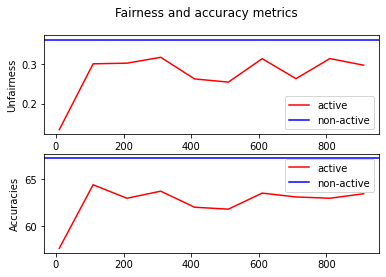

In [70]:
experiment(LogModel,RandomSelection,1000,100,"equal_opportunity","No_filter")